In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
from importlib import resources

from jax import grad, jit, vmap
import jax.numpy as jnp
import mols2grid
import numpy as np
import pymbar
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import timemachine

# Relative hydration free energy

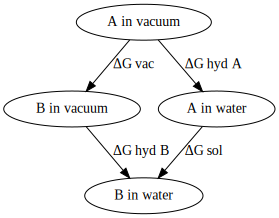

In [4]:
import graphviz

g = graphviz.Digraph()
g.node("A", label="A in vacuum")
g.node("B", label="B in vacuum")
g.node("AW", label="A in water")
g.node("BW", label="B in water")
g.edge("A", "B", label="<ΔG<SUB>vac</SUB>>")
g.edge("AW", "BW", label="<ΔG<SUB>sol</SUB>>")
g.edge("A", "AW", label="<ΔG<SUB>hyd A</SUB>>")
g.edge("B", "BW", label="<ΔG<SUB>hyd B</SUB>>")
g

\begin{equation}
0 = \Delta G_{\text{vac}} - \Delta G_{\text{sol}} - \Delta G_{\text{hyd A}} + \Delta G_{\text{hyd B}}
\end{equation}

\begin{equation}
\Delta \Delta G_{\text{hyd}} = \Delta G_{\text{hyd B}} - \Delta G_{\text{hyd A}} = \Delta G_{\text{sol}} - \Delta G_{\text{vac}}
\end{equation}

## Atom mapping

In [5]:
from timemachine.datasets import fetch_freesolv
from timemachine.fe import atom_mapping
from timemachine.fe.utils import get_mol_name, plot_atom_mapping_grid

In [6]:
mols = {get_mol_name(mol): mol for mol in fetch_freesolv()}

[12:46:07] Warning: molecule is tagged as 3D, but all Z coords are zero


In [7]:
mol_a = mols["mobley_3053621"]
mol_b = mols["mobley_3398536"]

In [8]:
mols2grid.display([mol_a, mol_b])

In [9]:
def compute_atom_mapping(threshold=2.0):
    assert mol_a.GetNumAtoms() == mol_b.GetNumAtoms()
    mcs_result = atom_mapping.mcs(mol_a, mol_b, threshold)
    query_mol = Chem.MolFromSmarts(mcs_result.smartsString)
    core = atom_mapping.get_core_by_mcs(mol_a, mol_b, query_mol, threshold)
    assert len(core) == mol_a.GetNumAtoms()
    return core

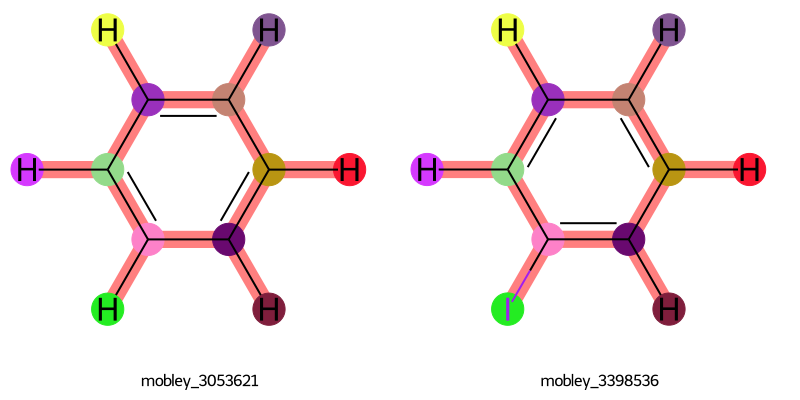

In [10]:
core = compute_atom_mapping()
plot_atom_mapping_grid(mol_a, mol_b, core)

## Vacuum leg

In [11]:
from timemachine.constants import DEFAULT_FF
from timemachine.fe.rbfe import estimate_relative_free_energy
from timemachine.ff import Forcefield

In [12]:
forcefield = Forcefield.load_from_file(DEFAULT_FF)

         Current function value: 174.479222
         Iterations: 47
         Function evaluations: 130
         Gradient evaluations: 118
         Current function value: 174.543727
         Iterations: 49
         Function evaluations: 208
         Gradient evaluations: 197
mobley_3053621_mobley_3398536_vacuum BAR: lambda 0 -> 1 dG: 0.016 +- 0.022 kJ/mol
         Current function value: 174.606385
         Iterations: 50
         Function evaluations: 238
         Gradient evaluations: 222
mobley_3053621_mobley_3398536_vacuum BAR: lambda 1 -> 2 dG: 0.025 +- 0.023 kJ/mol
         Current function value: 174.726206
         Iterations: 46
         Function evaluations: 124
         Gradient evaluations: 113
mobley_3053621_mobley_3398536_vacuum BAR: lambda 2 -> 3 dG: 0.061 +- 0.047 kJ/mol
         Current function value: 174.838886
         Iterations: 48
         Function evaluations: 134
         Gradient evaluations: 123
mobley_3053621_mobley_3398536_vacuum BAR: lambda 3 -> 4 dG: 0.04

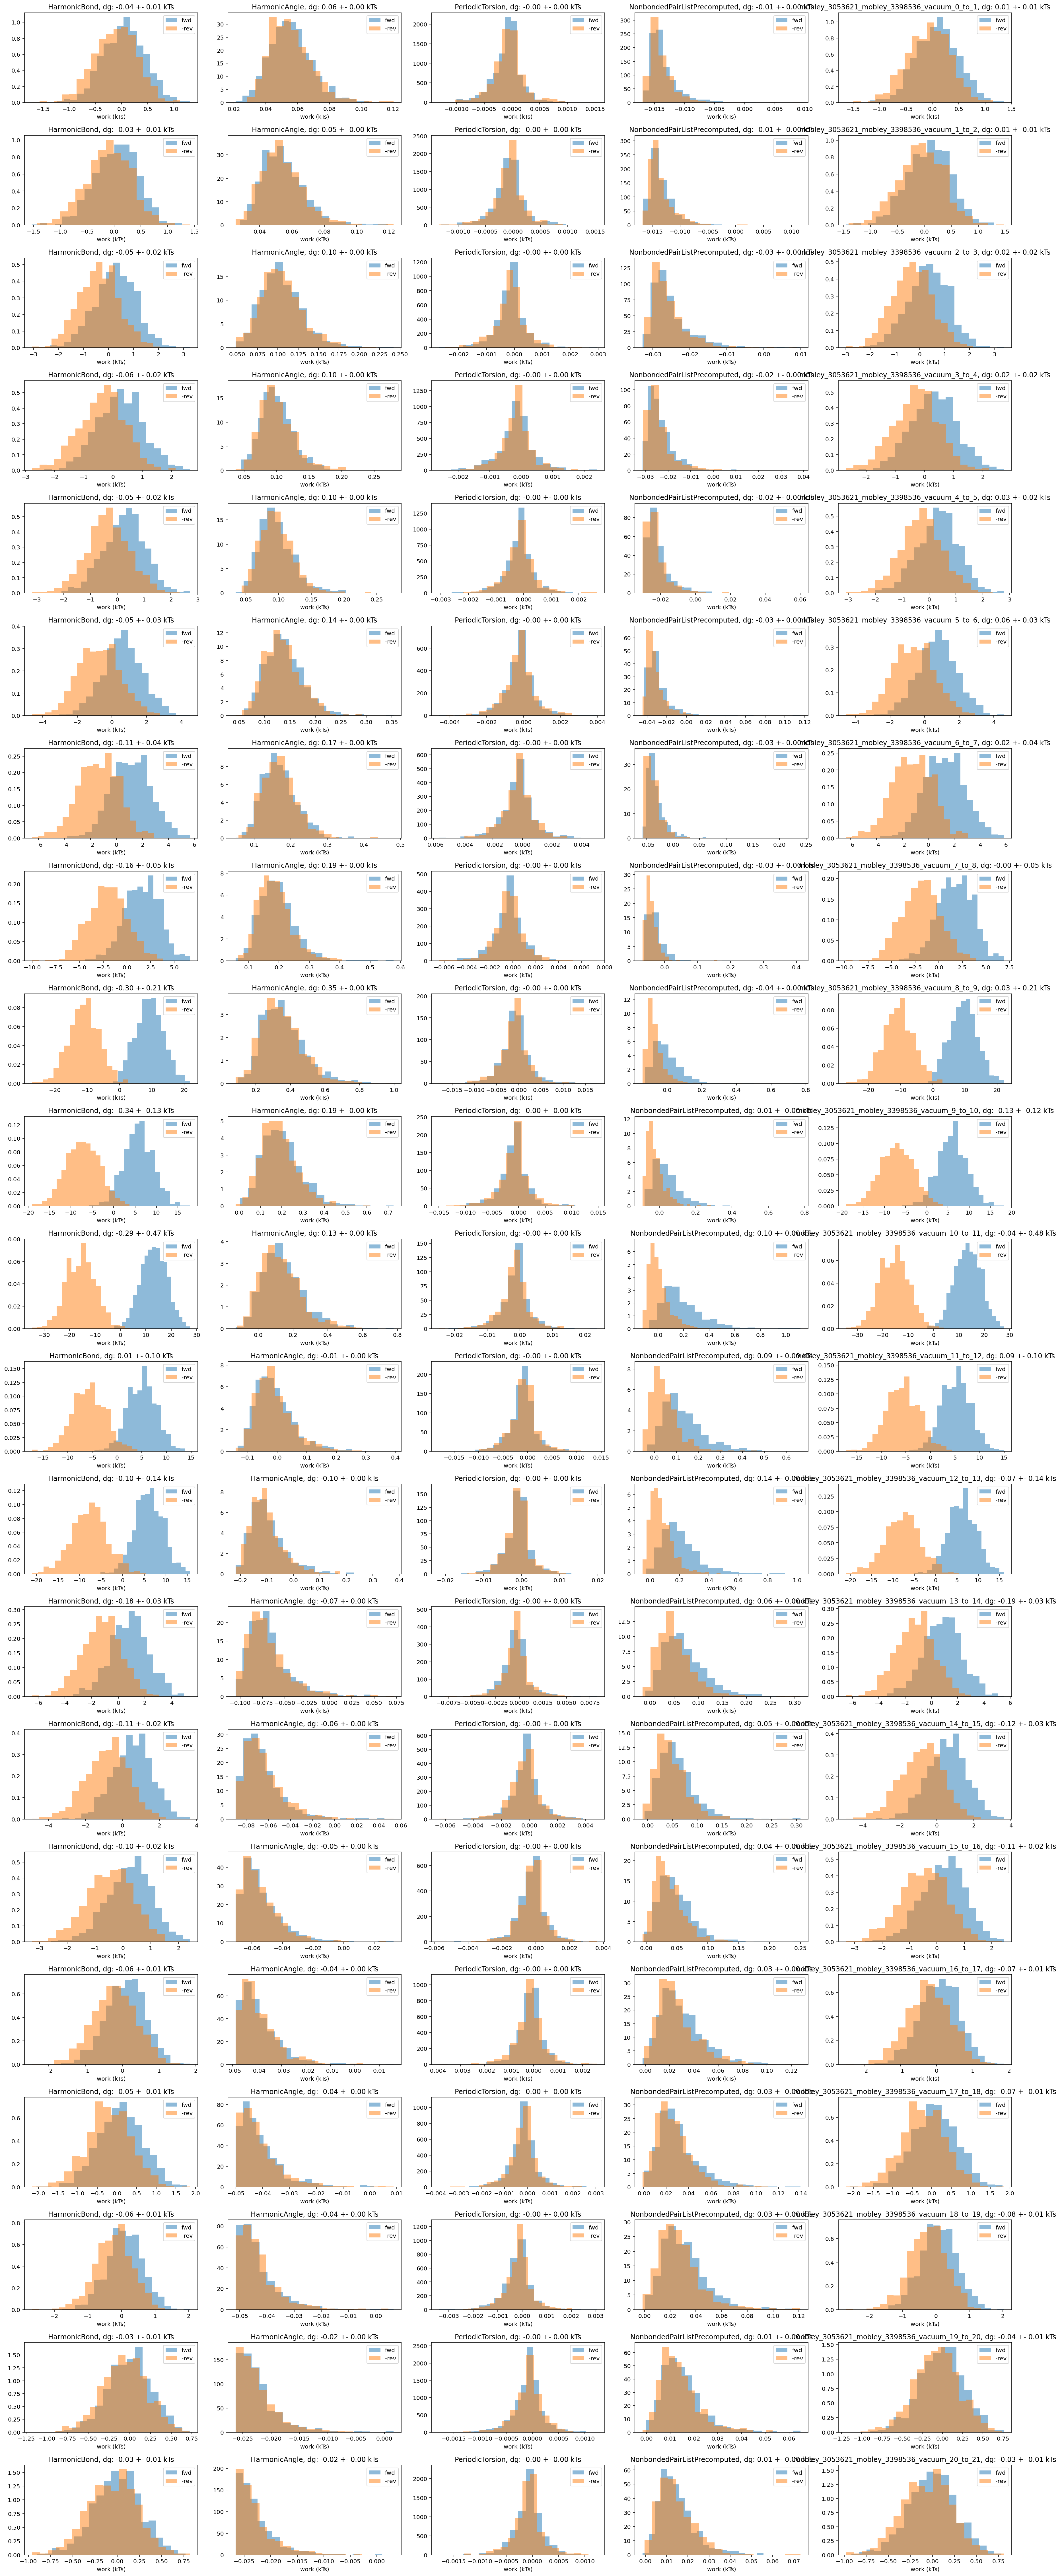

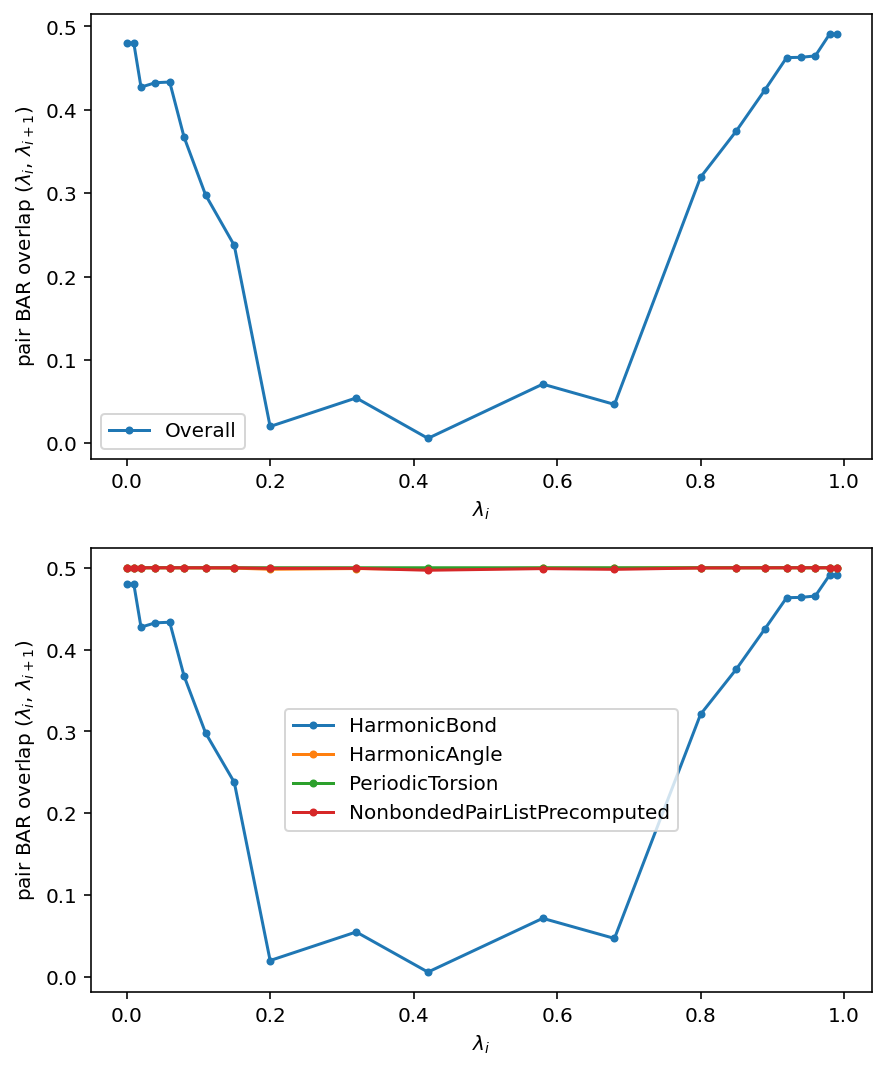

In [13]:
%%time
vacuum_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    host_config=None,
    seed=123,
    n_frames=1000,
    prefix="vacuum",
    n_eq_steps=10000,
)

In [14]:
from timemachine.constants import KCAL_TO_KJ

In [15]:
vacuum_dG = np.array(vacuum_res.all_dGs).sum() / KCAL_TO_KJ
vacuum_dG_err = np.linalg.norm(vacuum_res.all_errs) / KCAL_TO_KJ
vacuum_dG, vacuum_dG_err

(-0.3966758343419991, 0.3395468544871194)

## Solvent leg

In [16]:
from timemachine.fe.rbfe import HostConfig
from timemachine.md.builders import build_water_system

         Current function value: -104253.785256
         Iterations: 57
         Function evaluations: 140
         Gradient evaluations: 132
         Current function value: -104253.400331
         Iterations: 55
         Function evaluations: 156
         Gradient evaluations: 151
mobley_3053621_mobley_3398536_solvent BAR: lambda 0 -> 1 dG: 0.104 +- 0.022 kJ/mol
         Current function value: -104256.269386
         Iterations: 65
         Function evaluations: 158
         Gradient evaluations: 152
mobley_3053621_mobley_3398536_solvent BAR: lambda 1 -> 2 dG: 0.070 +- 0.022 kJ/mol
         Current function value: -104249.209882
         Iterations: 40
         Function evaluations: 124
         Gradient evaluations: 115
mobley_3053621_mobley_3398536_solvent BAR: lambda 2 -> 3 dG: 0.198 +- 0.044 kJ/mol
         Current function value: -104249.403833
         Iterations: 40
         Function evaluations: 130
         Gradient evaluations: 122
mobley_3053621_mobley_3398536_solvent BAR

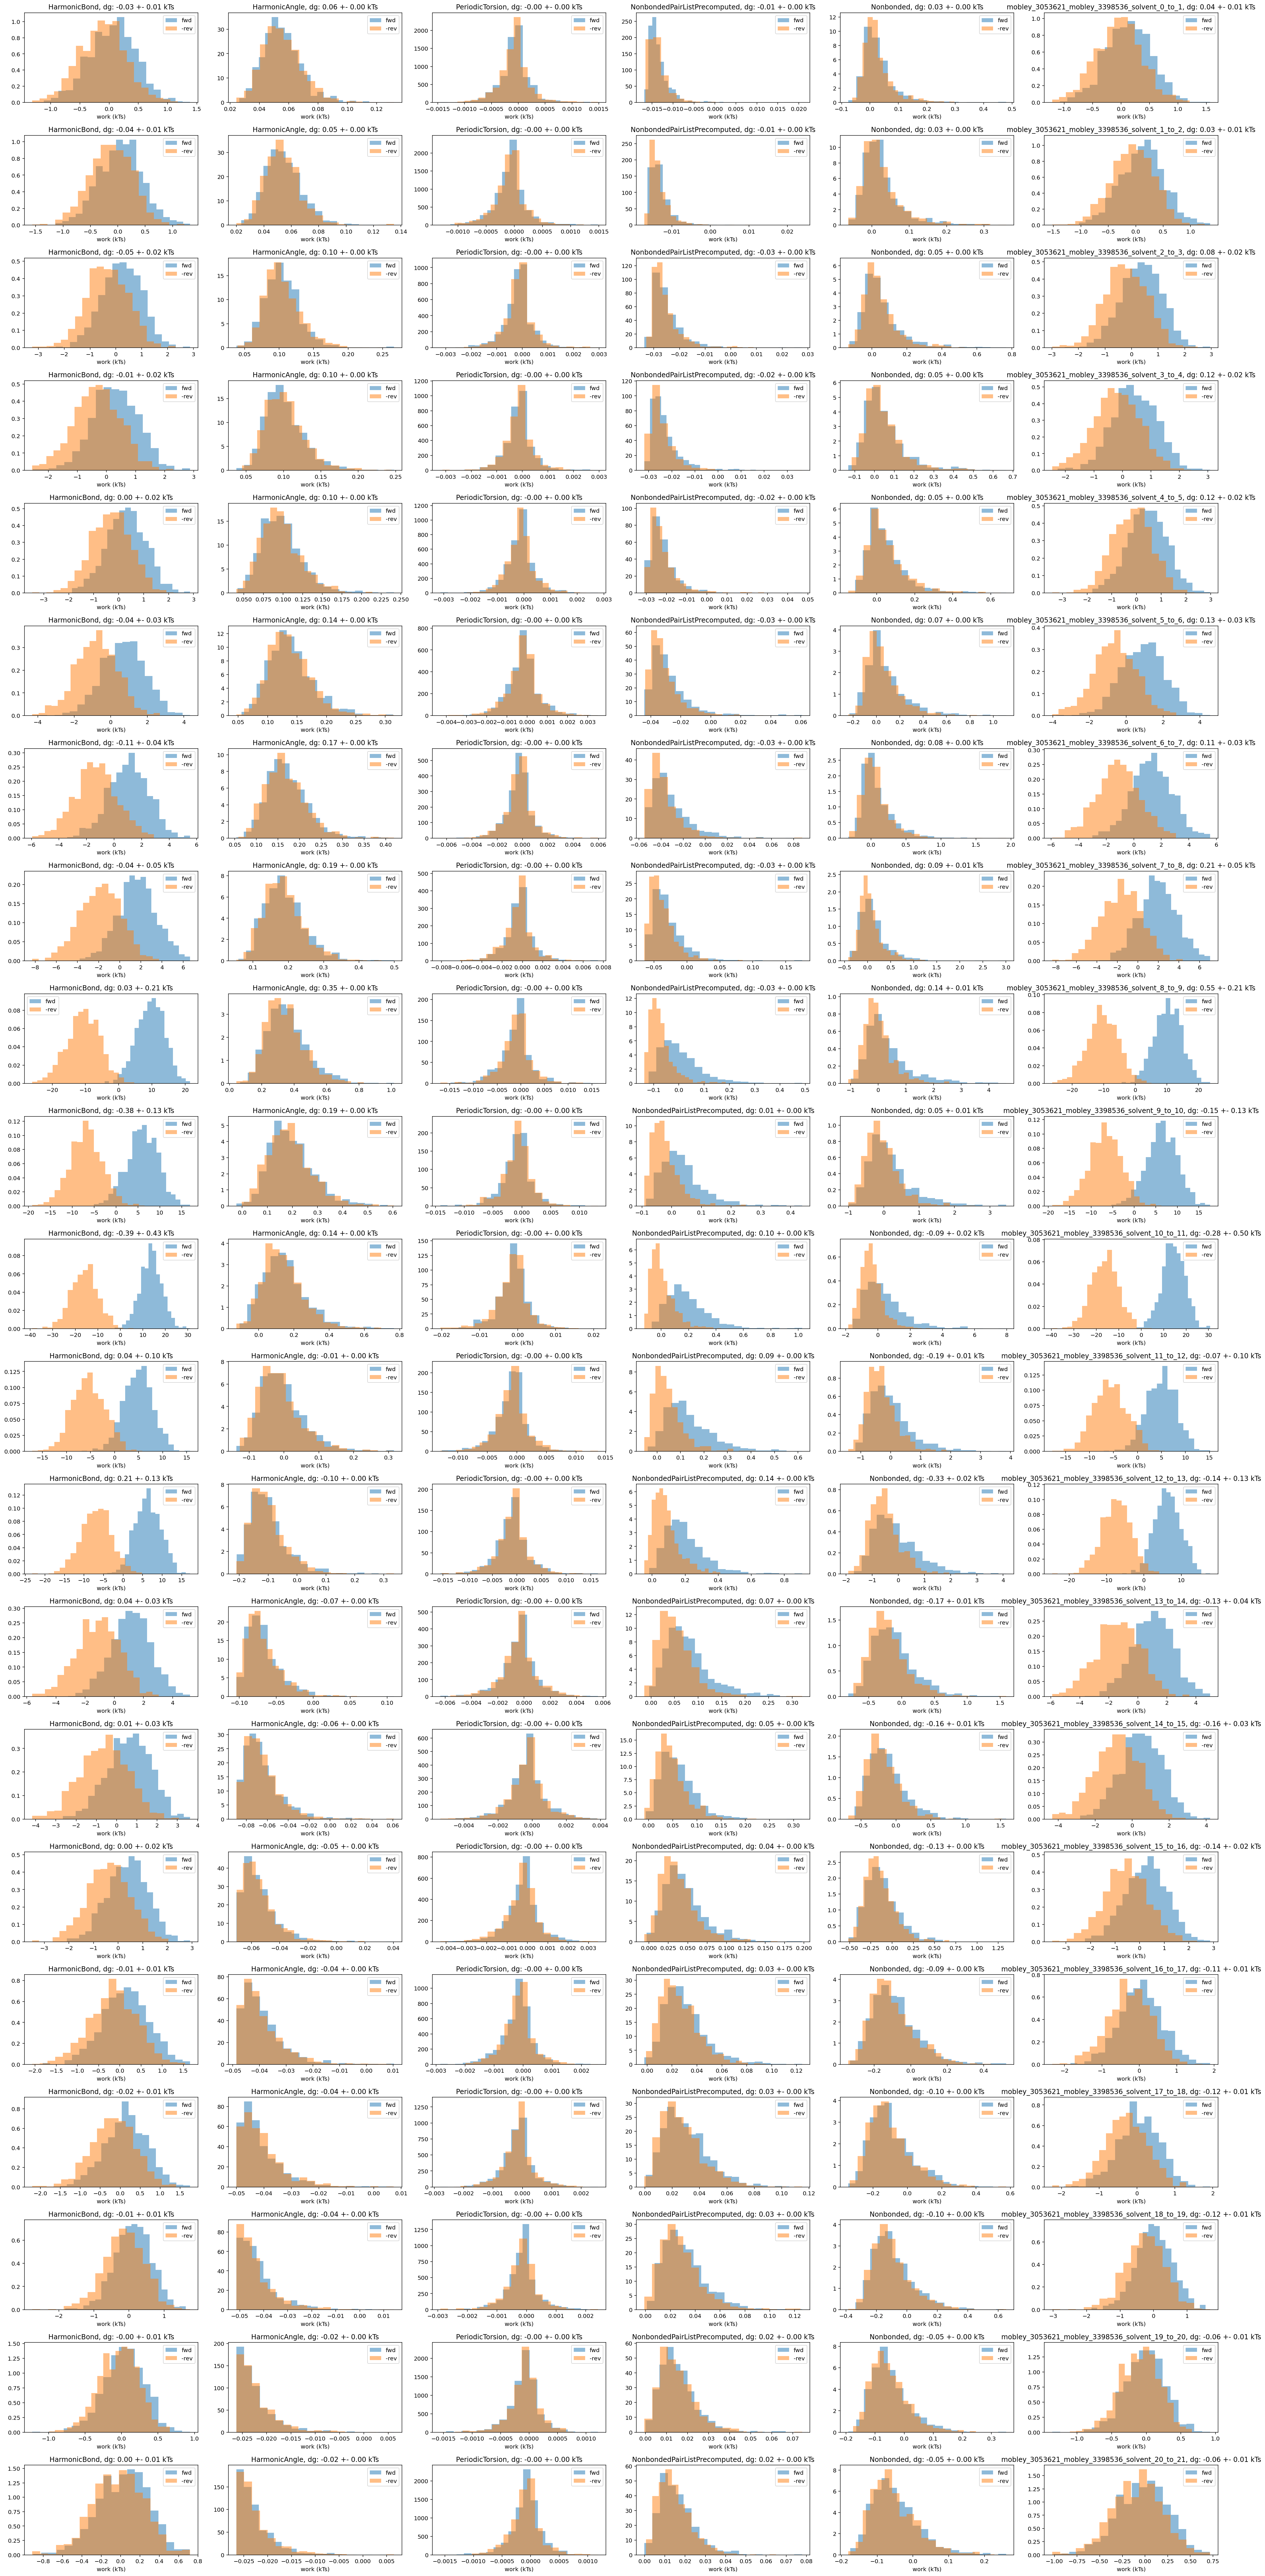

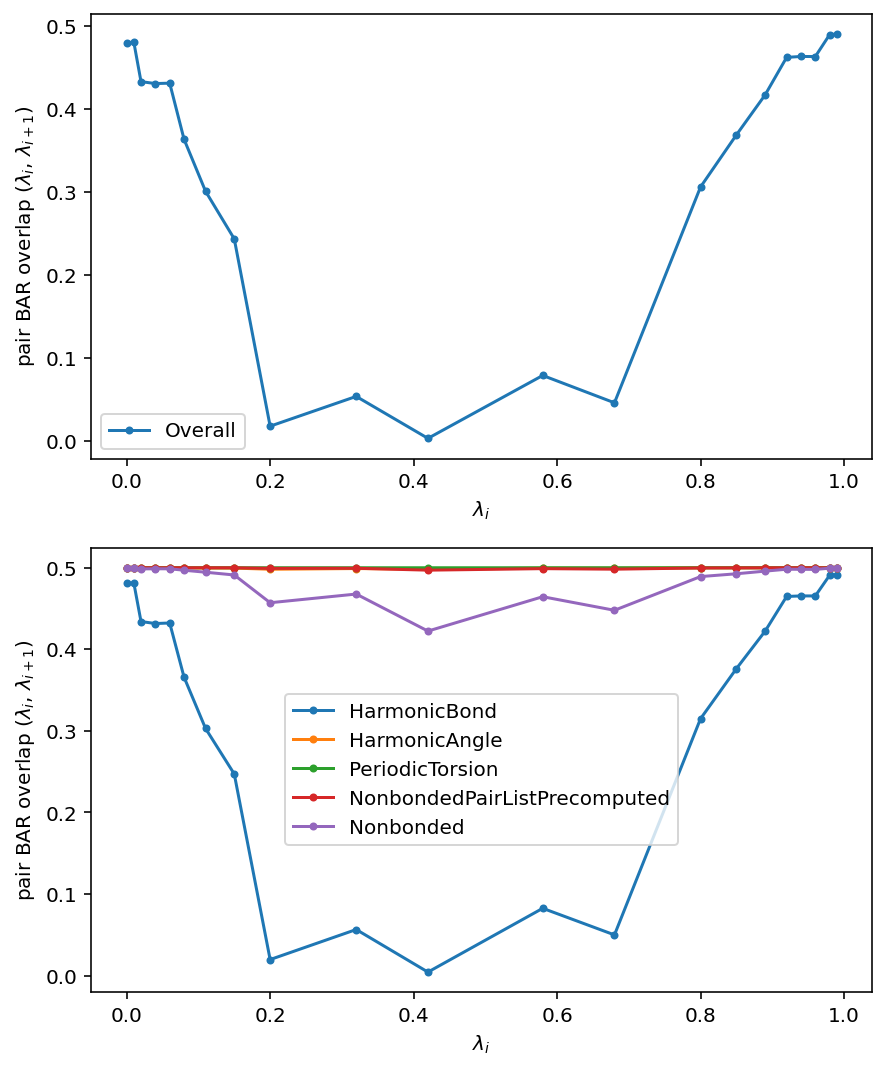

In [17]:
%%time
solvent_sys, solvent_conf, solvent_box, solvent_top = build_water_system(box_width=4.0)
solvent_box += np.diag([0.1, 0.1, 0.1])  # remove any possible clashes
solvent_host_config = HostConfig(solvent_sys, solvent_conf, solvent_box)

solvent_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    solvent_host_config,
    seed=123,
    n_frames=1000,
    prefix="solvent",
    n_eq_steps=10000,
)

In [18]:
solvent_dG = np.array(solvent_res.all_dGs).sum() / KCAL_TO_KJ
solvent_dG_err = np.linalg.norm(solvent_res.all_errs) / KCAL_TO_KJ
solvent_dG, solvent_dG_err

(-0.09201815716575029, 0.3535487674062993)

## $\Delta \Delta G_{\text{hyd}}$

In [19]:
ddG = solvent_dG - vacuum_dG
ddG_err = np.linalg.norm([solvent_dG_err, vacuum_dG_err])
ddG, ddG_err

(0.3046576771762488, 0.490192612476576)